# **Collecte de données**

Nous allons pour commencer télécharger des images dans une base de données, nous avons utilisé Kaggle pour cela. Et nous traiterons des images de chats/chatons.

In [ ]:
# !pip install sparqlwrapper

In [3]:
# !pip install --upgrade certifi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [79]:
import ssl
import os
import requests

# Désactiver la vérification du certificat SSL
ssl._create_default_https_context = ssl._create_unverified_context

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get cats
query = """
        SELECT DISTINCT ?cat ?image WHERE {
            ?cat wdt:P31 wd:Q146.
            ?cat wdt:P18 ?image.
        }
        LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def download_image(image_url, filename):
    # Fonction pour télécharger une image à partir de son URL
    response = requests.get(image_url)
    with open(filename, 'wb') as file:
        file.write(response.content)


array = []
results = get_results(endpoint_url, query)

# Créer un dossier pour enregistrer les images s'il n'existe pas
if not os.path.exists('cat_images'):
    os.makedirs('cat_images')

for result in results["results"]["bindings"]:
    cat_name = result["cat"]["value"]
    image_url = result["image"]["value"]
    
    # Ajouter le nom du fichier à partir de l'URL
    image_filename = 'cat_images/{}.jpg'.format(cat_name.split('/')[-1])
    
    # Ajouter le nom du fichier à la liste
    array.append((cat_name, image_filename))
    
    # Télécharger l'image dans le dossier 'cat_images'
    download_image(image_url, image_filename)




In [2]:
dataframe = pd.DataFrame(array, columns=["cat"])
dataframe = dataframe.astype(
    dtype={"cat": "<U200"}
)
dataframe

NameError: name 'pd' is not defined

In [ ]:
import requests
import shutil
import os


def download_image(url):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open(os.path.basename(url), "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

In [ ]:
dataframe.image.apply(download_image)

Fin de la partie 1

In [66]:
import os, sys
from PIL import Image
from PIL.ExifTags import TAGS
chemin_image='./cattt'
for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        try:
            imgfile = Image.open(filepath)
            # Recupérer les métadonnées EXIF
            exif_data = imgfile._getexif()
            if exif_data is None:
                 continue
            if exif_data:
                print("Métadonnées pour l'image {filename}:")
            for tag,value in exif_data.items():
                if tag in TAGS:
                    print(f"{TAGS[tag]}: {value}")
                else:
                    print(f"Aucune métadonné EXIF disponible pour l'image {imgfile}.")
        except (OSError, AttributeError)as e:
                print(f"Impossible de traiter l'image {imgfile}.{e}")

Nous n'avons aucune image avec un exif donc nous passons par uen autre méthode

In [67]:
import os, sys
from PIL import Image
from PIL.ExifTags import TAGS
import json 

chemin_image='./cattt'
chemin_json='./metadonnees_images.json'

metadatalist=[]

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        try:
            img = Image.open(filepath)
            metadata={
                 'file_name': fichier,
                 'size': img.size,
                 'format': img.format,
                 'mode': img.mode,
                 'exif': None
            }

            metadatalist.append(metadata)

            # Écrire la liste dans le fichier JSON
            with open(chemin_json, 'w') as f:
                json.dump(metadatalist, f)

        except (OSError, AttributeError)as e:
                print(f"Impossible de traiter l'image {imgfile}.{e}")

Nous enregistrons des tags pour chaque image

In [68]:
import os, sys
from PIL import Image
from PIL.ExifTags import TAGS
import json 

chemin_json='./images_tags.json'
chemin_image='./cattt'
images = []
limite= 60

data=[
    ["Funny","NotCute","BG","Fluffy","#cat_color"],
    ["NotFunny","Cute","BG","Fluffy","#cat_color"],
    ["Funny","Cute","BG","NotFluffy","#cat_color"],
    ["Funny","Cute","BG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","BG","Fluffy","#cat_color"],
    ["NotFunny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","Cute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","BG","NotFluffy","#cat_color"],
    ["Funny","Cute","NotBG","Fluffy","#cat_color"],
    ["NotFunny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","Cute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","Cute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","Cute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","BG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","NotBG","Fluffy","#cat_color"],
    ["NotFunny","NotCute","BG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","Cute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","Fluffy","#cat_color"],
    ["NotFunny","NotCute","BG","NotFluffy","#cat_color"],
    ["Funny","Cute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","Cute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","BG","Fluffy","#cat_color"],
    ["NotFunny","Cute","NotBG","Fluffy","#cat_color"],
    ["Funny","NotCute","BG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","BG","Fluffy","#cat_color"],
    ["NotFunny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","Cute","NotBG","NotFluffy","#cat_color"],
    ["NotFunny","NotCute","NotBG","NotFluffy","#cat_color"],
    ["Funny","NotCute","BG","NotFluffy","#cat_color"],
]

for count, file in enumerate(os.listdir(chemin_image)):
    if count >= limite:
        break  # Sort de la boucle une fois la limite atteinte
    if file.endswith('.jpg') :
        images.append(["./cattt/" + file])

for i in range(0,len(images)-1):
    images[i].append(data[i])


# Écrire la liste dans le fichier JSON
with open(chemin_json, 'w') as f:
    json.dump(images, f)


# **Analyses de données**

Après avoir reccuperer les donnees nous demondons aux utilisateurs de choisir des images

In [69]:
import ipywidgets as widgets
import os, sys
from PIL import Image
import json

from os import listdir

chemin_json='./images_favourite.json'
chemin_image='./cattt'
images = []
limite= 54

for count, file in enumerate(os.listdir(chemin_image)):
    if count >= limite:
        break  # Sort de la boucle une fois la limite atteinte
    if file.endswith('.jpg') :
        images.append("./cattt/" + file)

from ipywidgets import GridspecLayout, Image, interact
paths = []

checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
  file = open(img, "rb")
  image = file.read()
  image_widget = widgets.Image(
    value=image,
    format='png',
    width=100,
    height=100,
  )
  layout[i,0] = image_widget
  layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    global paths
    paths = []
    selected_paths = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    with output:
        output.clear_output()
        print("Selected Images:")
        for path in selected_paths:
            print(path)
            paths.append(path)
    print(paths)
    # Écrire la liste dans le fichier JSON
    with open(chemin_json, 'w') as f:
       json.dump(paths, f)
        

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(layout, button, output)








GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\…

Button(description='Select', style=ButtonStyle())

Output()

['./cattt/00000012_025.jpg', './cattt/00000003_020.jpg', './cattt/00000006_011.jpg']


Nous faisons le choix d'utiliser la classification algorithmique 

In [70]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import json,os
from sklearn.ensemble import RandomForestClassifier
import itertools

data=[
    ["Funny","NotCute","BG","#cat_color"],
    ["NotFunny","Cute","BG","#cat_color"],
    ["Funny","Cute","BG","#cat_color"],
    ["Funny","Cute","BG","#cat_color"],
    ["NotFunny","NotCute","BG","#cat_color"],
    ["NotFunny","NotCute","NotBG","#cat_color"],
    ["NotFunny","Cute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["NotFunny","NotCute","BG","#cat_color"],
    ["Funny","Cute","NotBG","#cat_color"],
    ["NotFunny","NotCute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["Funny","Cute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["NotFunny","Cute","NotBG","#cat_color"],
    ["NotFunny","Cute","NotBG","#cat_color"],
    ["NotFunny","NotCute","BG","#cat_color"],
    ["NotFunny","NotCute","NotBG","#cat_color"],
    ["NotFunny","NotCute","BG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["Funny","Cute","NotBG","#cat_color"],
    ["Funny","NotCute","NotBG","#cat_color"],
    ["NotFunny","NotCute","BG","#cat_color"],
    ["NotFunny","Cute","NotBG","#cat_color"],

]

chemin_image='./cattt'
limite= 45
chemin_json='./images_favourite.json'
result=[]

with open(chemin_json, 'r') as f:
    liste_fichiers = json.load(f)

for count, file in enumerate(os.listdir(chemin_image)):
    if count >= limite:
        break  # Sort de la boucle une fois la limite atteinte
    if file.endswith('.jpg') :
        file="./cattt/" + file
        if file in liste_fichiers:
            result.append("Favourite")
        else:
            result.append("NotFavourite")

print(result)
print(liste_fichiers)


# Encode categorical features and labels
label_encoders = [LabelEncoder() for _ in range(len(data[0]))]
encoded_data = []
for i, column in enumerate(zip(*data)):
    encoded_data.append(label_encoders[i].fit_transform(column))

X = list(zip(*encoded_data))  # Features
y = result  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression classifier
classifier1 = svm.SVC()
classifier1.fit(X_train, y_train)

classifier2 = RandomForestClassifier(random_state=42)
classifier2.fit(X, y)

# Predictions
y_pred = classifier1.predict(X_test)

# Evaluate the classifier 1
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Sample prediction
sample_item = ["Funny", "NotCute", "BG", "#cat_color"]  # Sample item attributes
encoded_item = [label_encoders[i].transform([val])[0] for i, val in enumerate(sample_item)]
prediction = classifier1.predict([encoded_item])[0]
print(f"Prediction for the sample item: {prediction}")

predictions = classifier2.predict(X)

# Find a sample predicted as "Favourite"
for i, pred in enumerate(predictions):
    if pred == "Favourite":
        print("Attributes for the predicted 'Favourite' sample:")
        print(data[i])
        break

['Favourite', 'Favourite', 'Favourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite', 'NotFavourite']
['./cattt/00000012_025.jpg', './cattt/00000003_020.jpg', './cattt/00000006_011.jpg']
Accuracy: 0.8333333333333334
Prediction for the sample item: NotFavourite
Attributes for the predicted 'Favourite' sample:
['Funny', 'NotCute', 'BG', '#cat_color']


./cattt/00000012_025.jpg


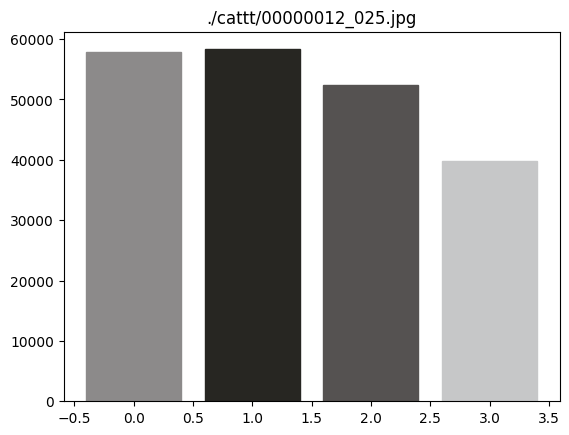

./cattt/00000003_020.jpg


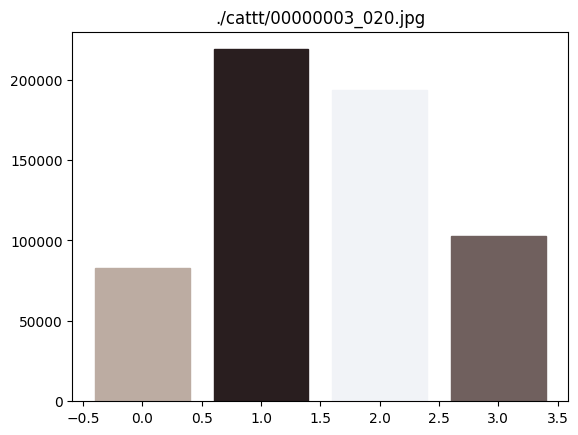

./cattt/00000006_011.jpg


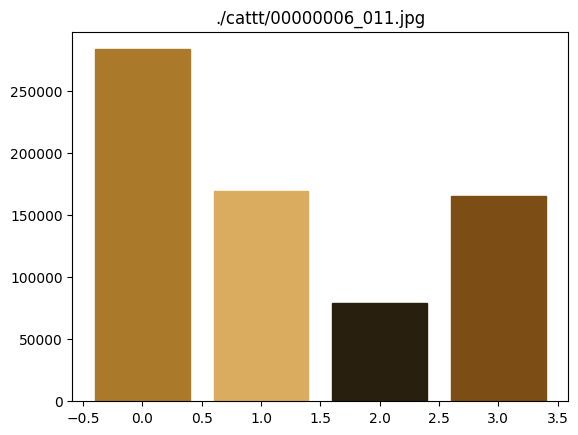

./cattt/00000017_000.jpg


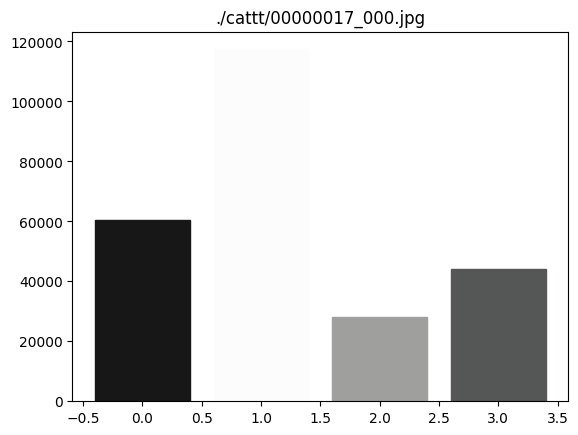

./cattt/00000007_014.jpg


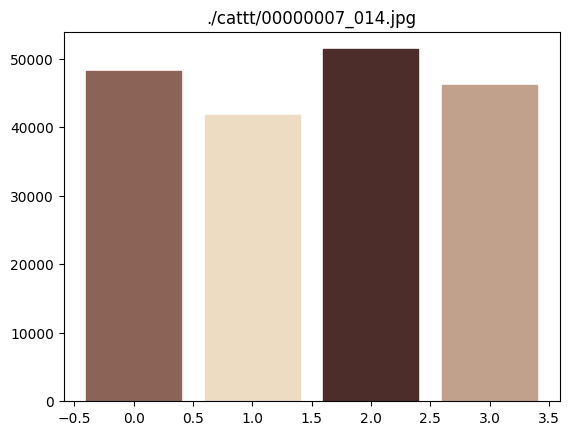

./cattt/00000007_000.jpg


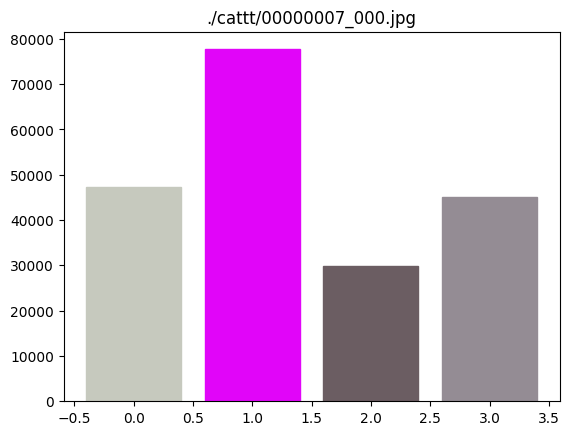

./cattt/00000007_015.jpg


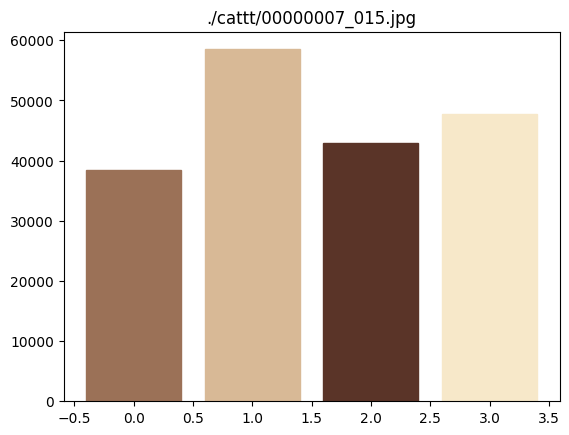

./cattt/00000013_021.jpg


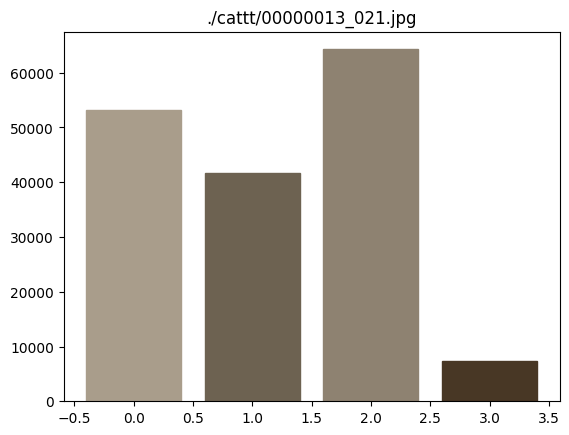

./cattt/00000003_009.jpg


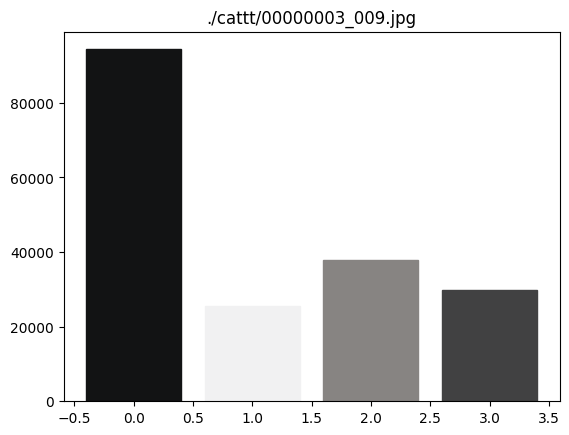

./cattt/00000013_009.jpg


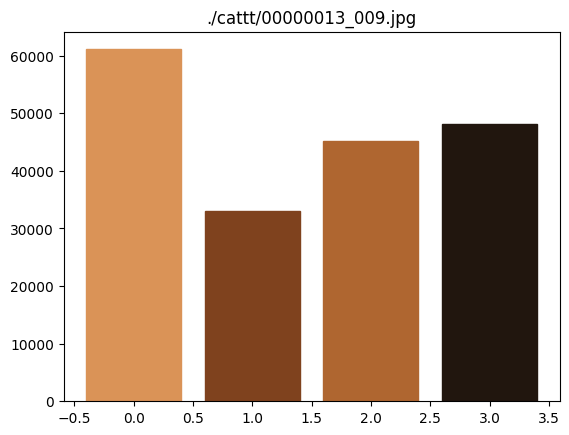

./cattt/00000002_026.jpg


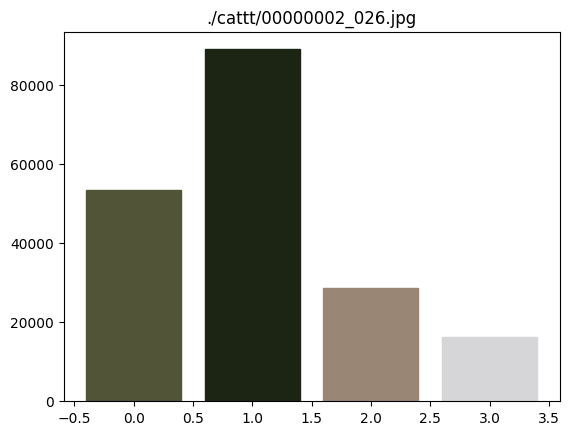

./cattt/00000006_006.jpg


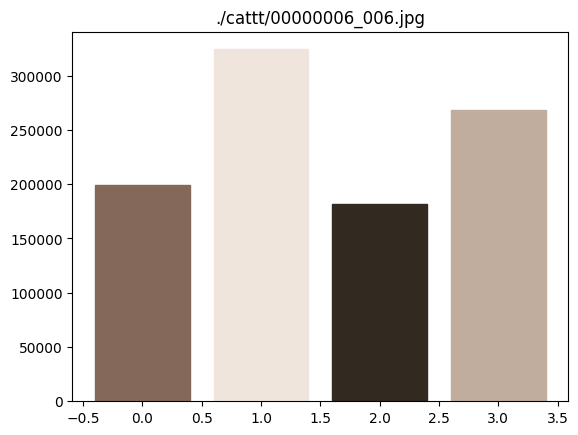

./cattt/00000007_002.jpg


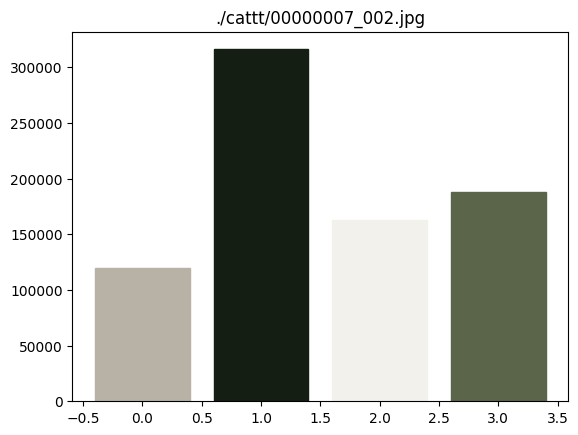

./cattt/00000016_013.jpg


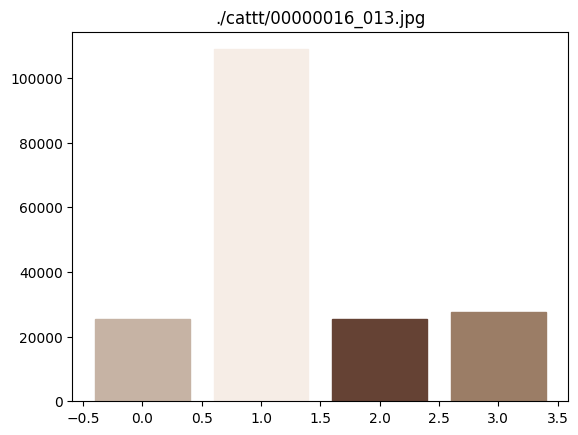

./cattt/00000006_013.jpg


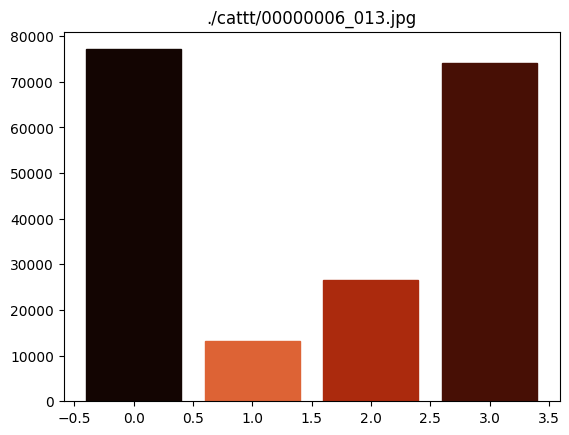

./cattt/00000013_022.jpg


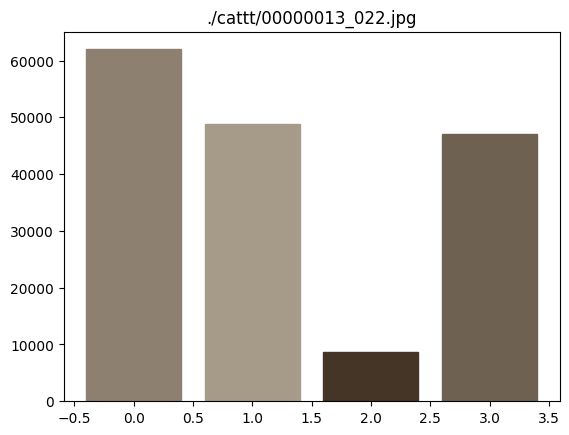

./cattt/00000013_026.jpg


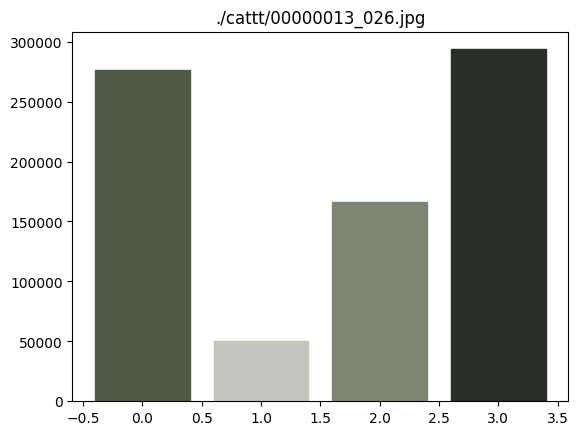

./cattt/00000003_026.jpg


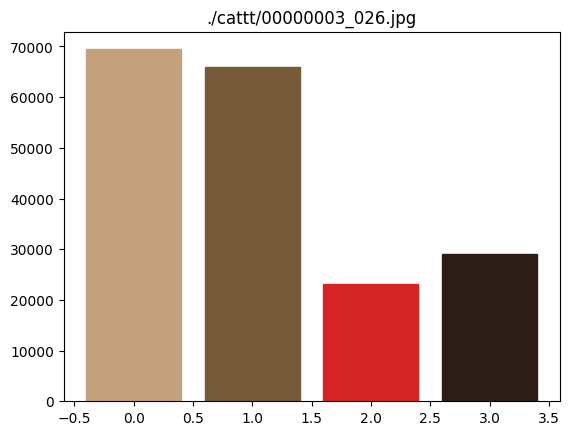

./cattt/00000007_006.jpg


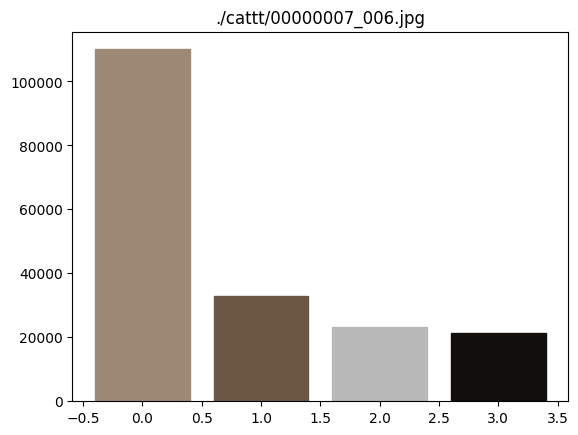

./cattt/00000007_012.jpg


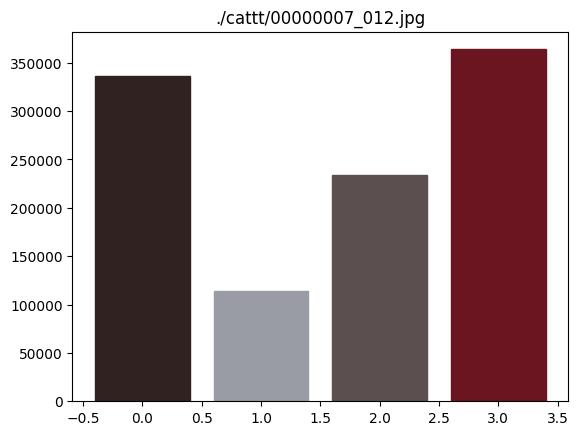

./cattt/00000007_013.jpg


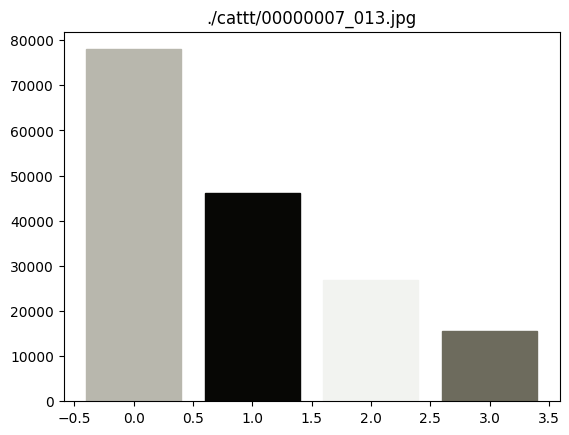

./cattt/00000007_007.jpg


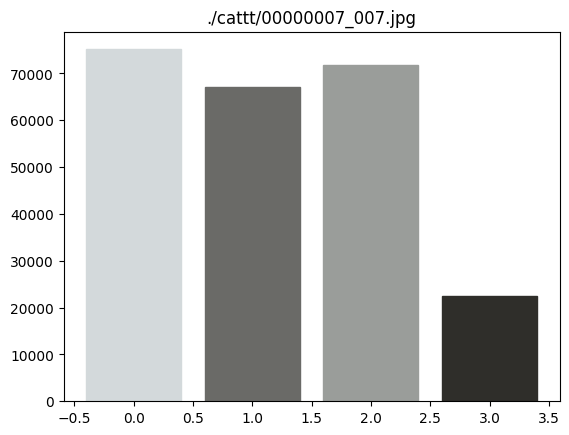

./cattt/00000006_016.jpg


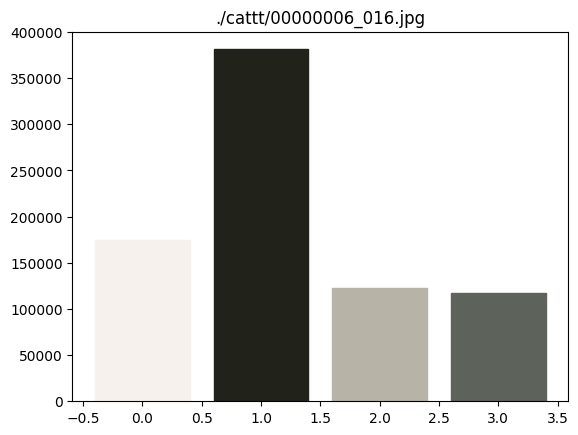

./cattt/00000012_022.jpg


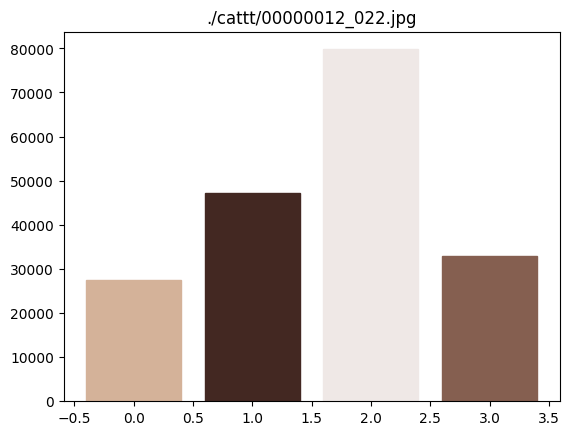

./cattt/00000002_008.jpg


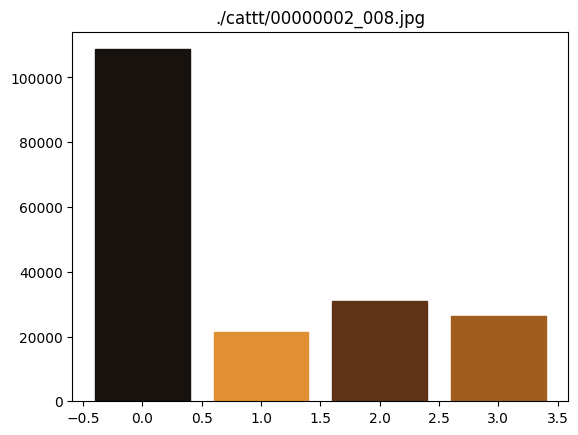

./cattt/00000013_025.jpg


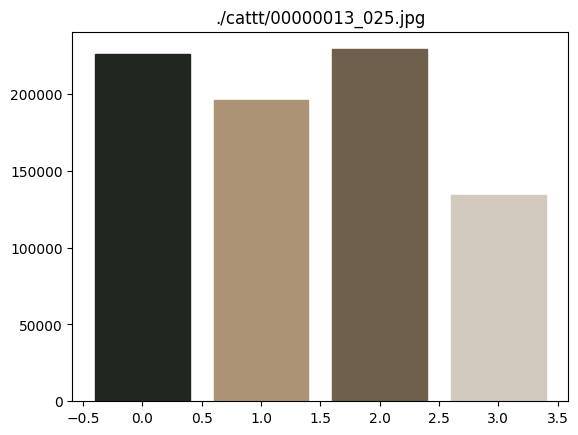

./cattt/00000007_005.jpg


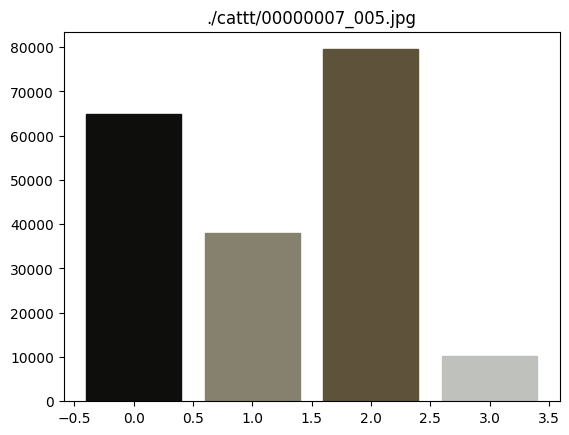

./cattt/00000007_004.jpg


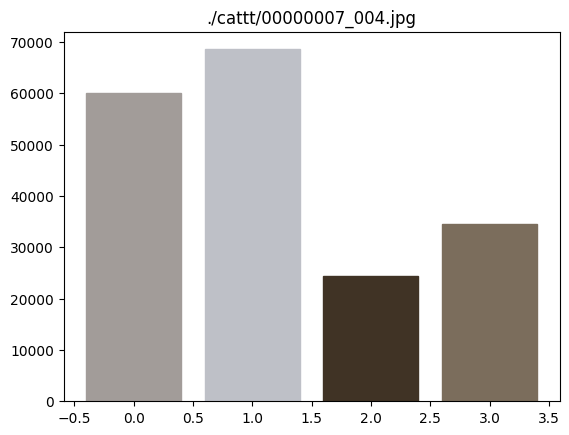

./cattt/00000006_029.jpg


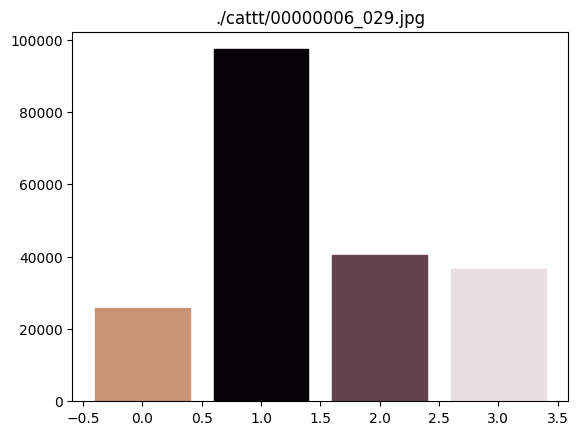

./cattt/00000016_015.jpg


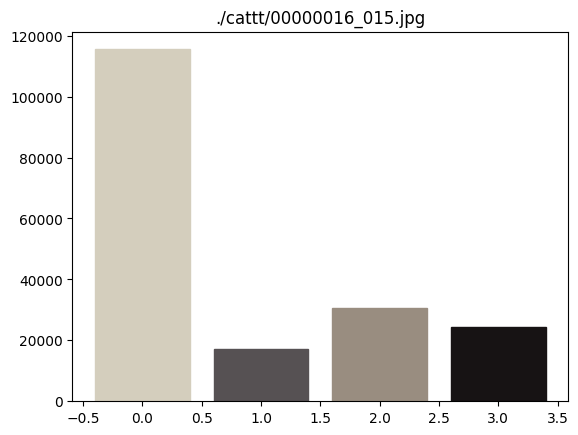

./cattt/00000003_024.jpg


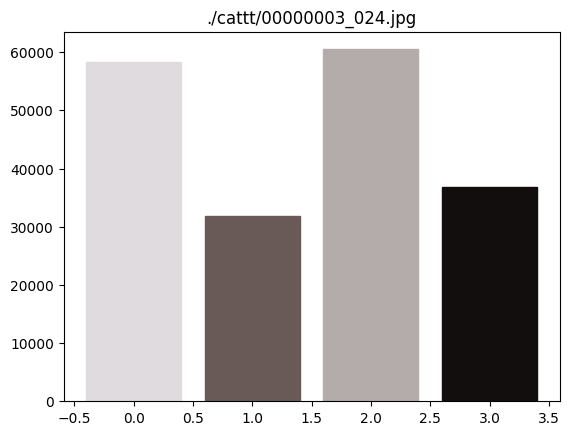

./cattt/00000004_003.jpg


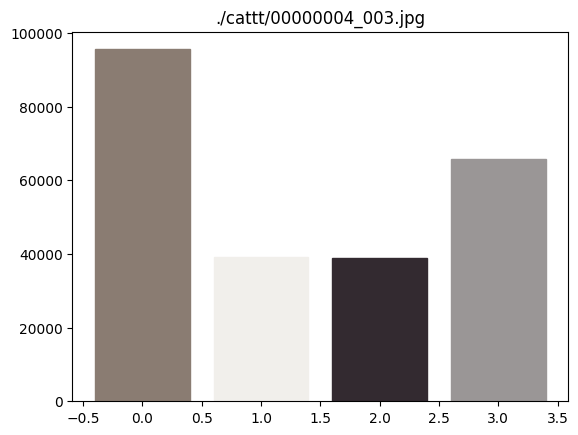

./cattt/00000014_003.jpg


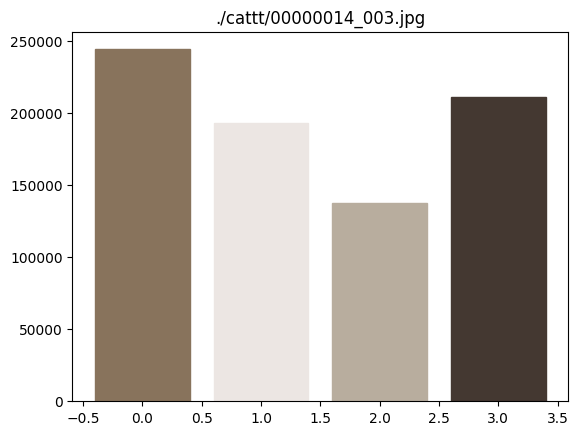

./cattt/00000005_012.jpg


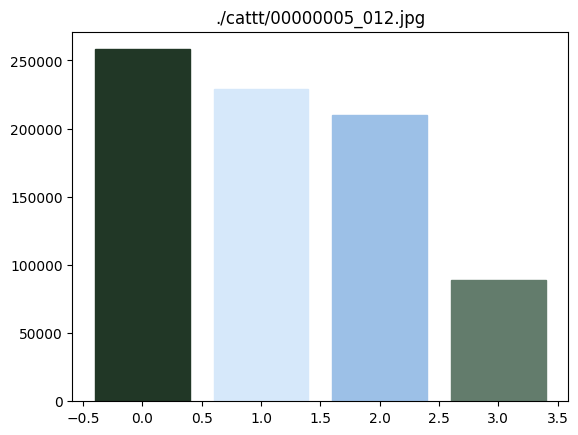

./cattt/00000011_027.jpg


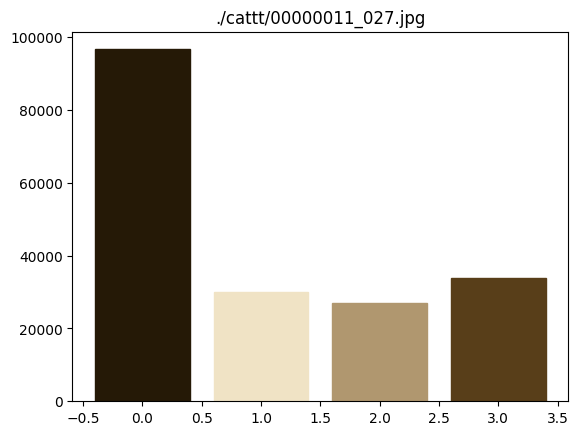

./cattt/00000001_027.jpg


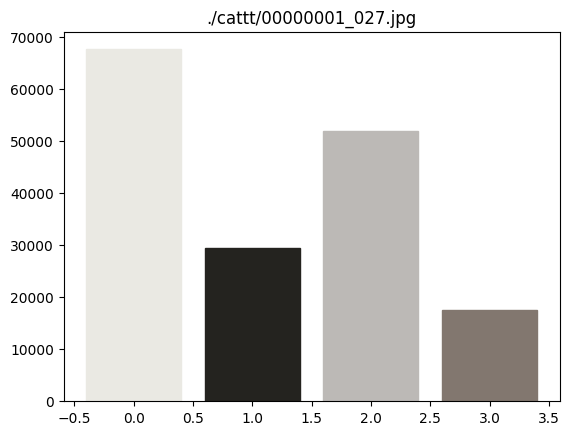

./cattt/00000015_013.jpg


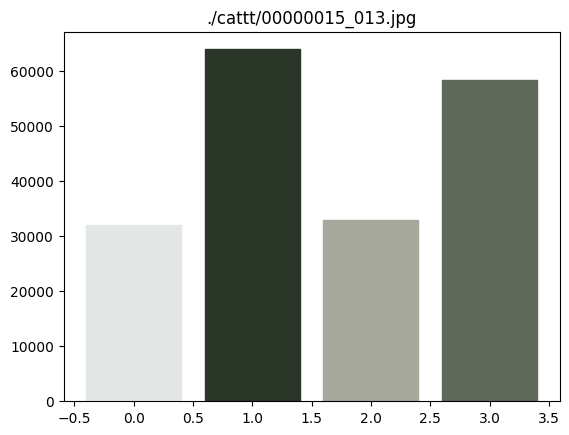

./cattt/00000008_018.jpg


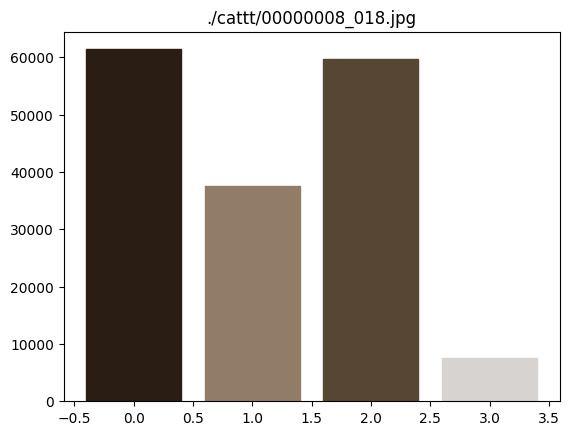

./cattt/00000009_021.jpg


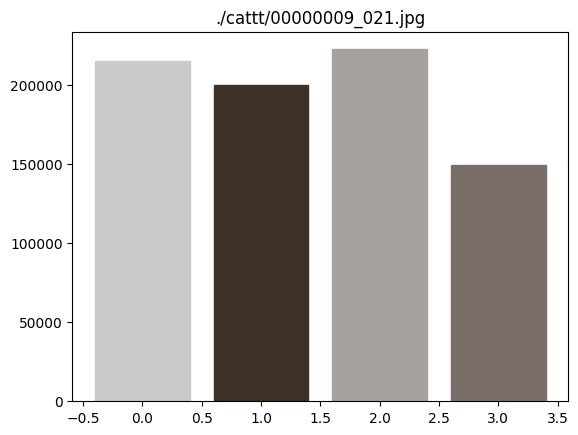

./cattt/00000009_009.jpg


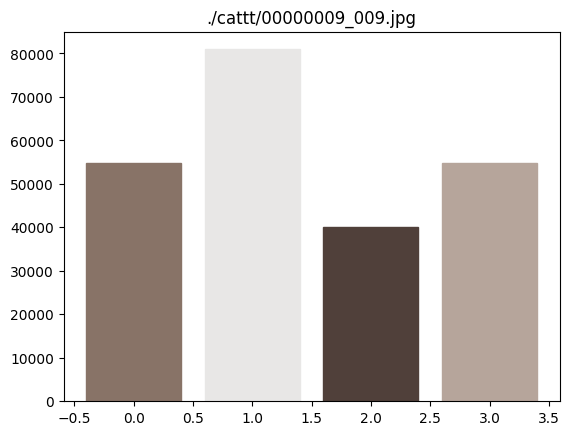

./cattt/00000004_028.jpg


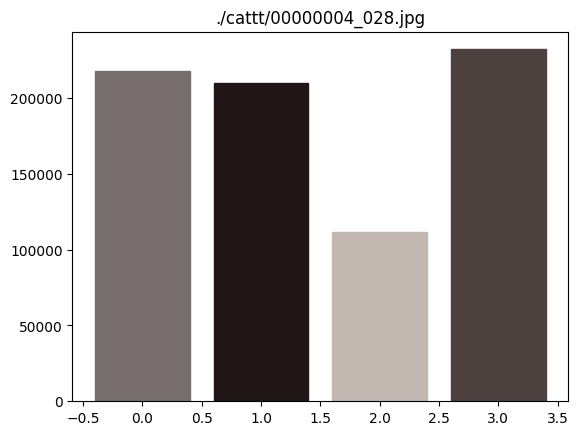

./cattt/00000009_023.jpg


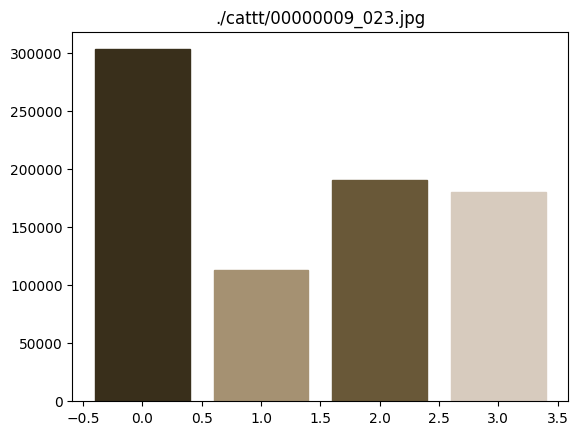

./cattt/00000011_025.jpg


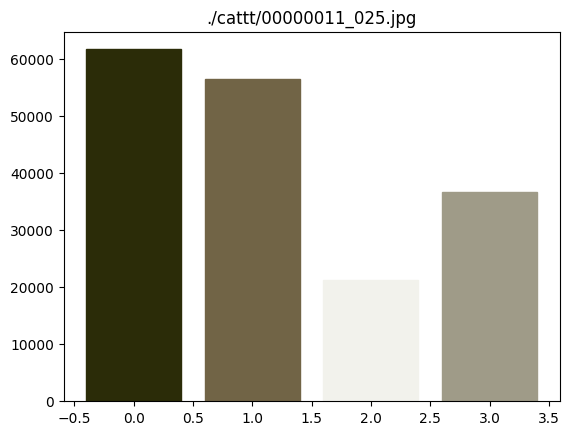

./cattt/00000001_024.jpg


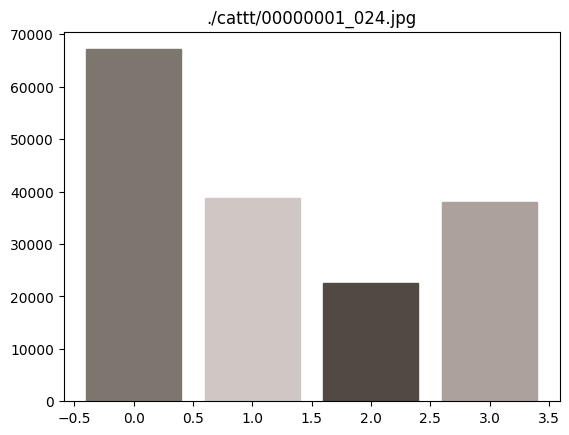

./cattt/00000009_022.jpg


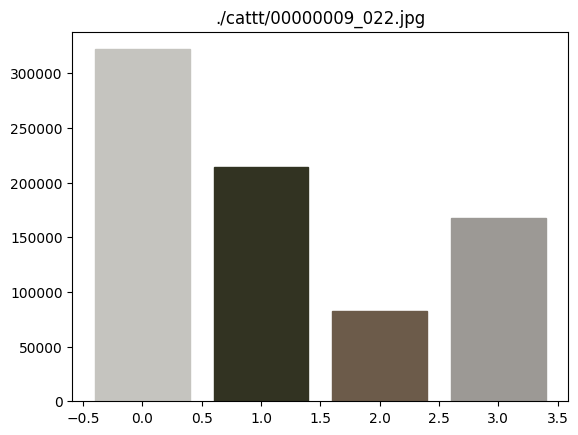

./cattt/00000014_001.jpg


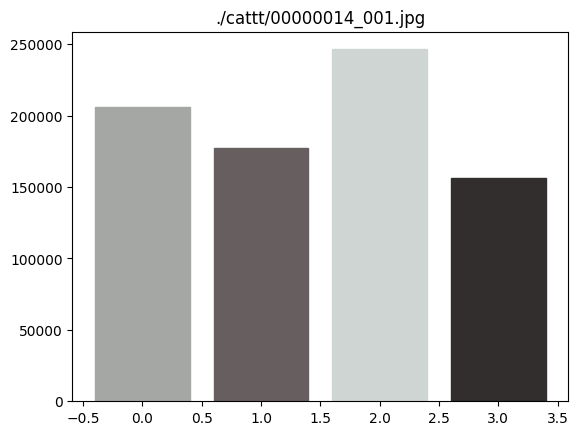

./cattt/00000009_026.jpg


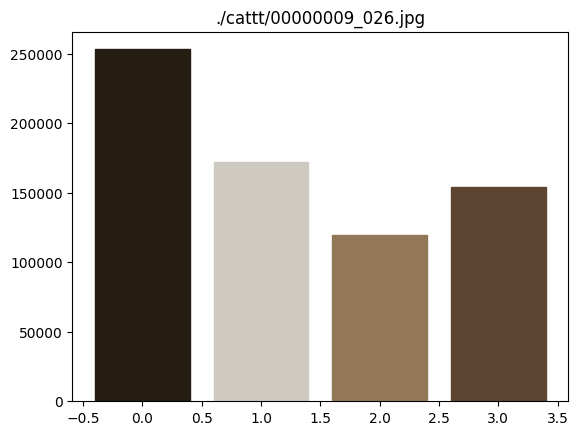

./cattt/00000005_000.jpg


KeyboardInterrupt: 

In [ ]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans

chemin_image='./cattt'

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        print(filepath)
        imgfile = Image.open(filepath)
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
        clusters = KMeans(n_clusters=4, n_init=2)
        clusters.fit(numarray)
        npbins = numpy.arange(0, 5)
        histogram = numpy.histogram(clusters.labels_, bins=npbins)
        labels = numpy.unique(clusters.labels_)
        barlist = plot.bar(labels, histogram[0])
        for i in range(4):
            barlist[i].set_color(
                "#%02x%02x%02x"
                % (
                    math.ceil(clusters.cluster_centers_[i][0]),
                    math.ceil(clusters.cluster_centers_[i][1]),
                    math.ceil(clusters.cluster_centers_[i][2]),
                )
            )
        plot.title(filepath,loc='center')
        plot.show()



Visualisation des données 

In [ ]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        imgfile = Image.open(fichier)
        histogram = imgfile.histogram()
        red = histogram[0:255]
        green = histogram[256:511]
        blue = histogram[512:767]
        x = range(255)
        y = []
        for i in x:
            y.append((red[i], green[i], blue[i]))
        figure, axes = plot.subplots()
        axes.set_prop_cycle("color", ["red", "green", "blue"])
        plot.plot(x, y)
        plot.show()


NameError: name 'chemin_image' is not defined